In [1]:
!pip install --upgrade --quiet git+https://github.com/dtonderski/DeepSudoku

In [2]:
!pip show deepsudoku

Name: deepsudoku
Version: 0.8.4
Summary: Solving Sudokus using a Neural Network assisted Monte-Carlo approach.
Home-page: https://github.com/dtonderski/DeepSudoku
Author: davton
Author-email: dtonderski@gmail.com
License: GNU GPLv3
Location: /usr/local/lib/python3.9/dist-packages
Requires: einops, numpy, py-sudoku, torch
Required-by: 


### Difficulty re-determination for Sudoker
We have now decided to use the Sudoker, so we can re-decide the difficulty. We have a pretty well-trained version, so let's approximate and calculate difficulty using it

### Data

In [3]:
from deepsudoku.utils import data_utils

In [4]:
train_sudokus_raw, val_sudokus_raw, test_sudokus_raw = data_utils.load_data()

### Network

In [5]:
from deepsudoku.nn import sudoker, loss
import torch

In [6]:
network = sudoker.Sudoker(12,192,3,768,0).cuda()

In [7]:
models = {"ViTTiSudoker": lambda: sudoker.Sudoker(12,192,3,768,0).cuda()}
batch_sizes = {"ViTTiSudoker": 128}
lrs = {"ViTTiSudoker": 1e-5}

In [13]:
model_name = "ViTTiSudoker"
network, batch_size = models[model_name](), batch_sizes[model_name]
loss_fn = loss.loss

In [14]:
model_path = f"models/training/{model_name}"

checkpoint = torch.load(model_path)
network.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Difficulty determination

In [15]:
from deepsudoku.utils import network_utils
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np

In [16]:
difficulty_sudokus = data_utils.make_moves(train_sudokus_raw + val_sudokus_raw, n_moves_distribution=data_utils.uniform_possible_moves_distribution)

In [17]:
loss_by_empty_cells = defaultdict(list)

for batch_index in range(0, len(difficulty_sudokus), batch_size):
    print(f"{batch_index}/{len(difficulty_sudokus)}", end = "\r")
    batch_sudokus = difficulty_sudokus[batch_index:batch_index+batch_size]

    x_np, y_np = data_utils.generate_numpy_batch(batch_sudokus, augment = False)
    x_difficulty, y_difficulty = network_utils.numpy_batch_to_pytorch(x_np, y_np, 'cuda')
    y_pred_difficulty = network(x_difficulty)

    for i in range(x_difficulty.shape[0]):
        x      = x_difficulty[i:i+1]
        y      = (y_difficulty[0][i:i+1],      y_difficulty[1][i:i+1])
        y_pred = (y_pred_difficulty[0][i:i+1], y_pred_difficulty[1][i:i+1])

        empty_cells = int((x == 0).sum().cpu())

        loss, _ = loss_fn(x, y_pred, y)
        loss_by_empty_cells[empty_cells].append(loss.detach().cpu().item())

In [18]:
loss_by_empty_cells_avgd = {k: sum(v)/len(v) for k, v in loss_by_empty_cells.items()}

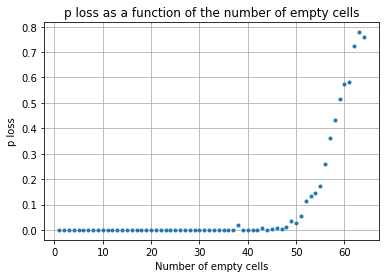

In [19]:
plt.plot(loss_by_empty_cells_avgd.keys(), loss_by_empty_cells_avgd.values(), '.')
plt.grid()
plt.xlabel('Number of empty cells')
plt.ylabel('p loss')
plt.title('p loss as a function of the number of empty cells')
plt.show()


We don't have any data on how "difficult" a zero-empty-cells sudoku is, so extend by assuming it's the same as the one-empty-cell sudoku.


In [20]:
difficulty = [x[1] for x in sorted(loss_by_empty_cells_avgd.items())]
difficulty = [difficulty[0]] + difficulty
difficulty = [x / difficulty[-1] for x in difficulty]

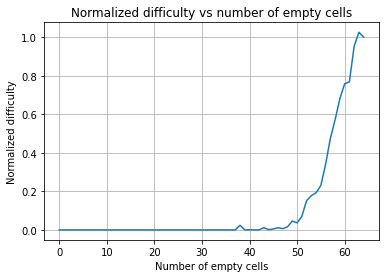

In [21]:
plt.plot(difficulty)
plt.title("Normalized difficulty vs number of empty cells")
plt.xlabel('Number of empty cells')
plt.ylabel('Normalized difficulty')
plt.grid()
plt.show()

Save the normalized and extended difficulty as a numpy array.

In [22]:
data_utils.save_difficulty(difficulty)

Load to make sure everything works fine

In [23]:
difficulty_loaded = data_utils.load_difficulty()
assert np.all(difficulty_loaded == difficulty)

### Evaluate

In [24]:
from deepsudoku.nn.evaluation import evaluate, get_averages, print_evaluation, categorical_accuracy, binary_accuracy
from deepsudoku.montecarlo.simulation import get_n_simulations_function

In [25]:
val_sudokus = data_utils.make_moves(val_sudokus_raw, n_moves_distribution=data_utils.difficulty_uniform_combo_distribution)

In [26]:
n_simulations_function = get_n_simulations_function(1, 32)
moves_before_failure_dict, percentage_completed_dict = evaluate(val_sudokus, network, n_simulations_function, 
                                                                n_played_sudokus = len(val_sudokus))

avg_moves_dict, avg_percentage_dict = get_averages(moves_before_failure_dict, percentage_completed_dict)

print_evaluation(avg_moves_dict, avg_percentage_dict)

1/1160, time = 2022-12-19 16:44:57.646742
17/1160, time = 2022-12-19 16:45:10.718612
33/1160, time = 2022-12-19 16:45:27.278156
49/1160, time = 2022-12-19 16:45:48.471725
65/1160, time = 2022-12-19 16:46:06.370592
81/1160, time = 2022-12-19 16:46:20.559610
97/1160, time = 2022-12-19 16:46:43.432129
113/1160, time = 2022-12-19 16:46:55.486361
129/1160, time = 2022-12-19 16:47:15.239477
145/1160, time = 2022-12-19 16:47:37.212448
161/1160, time = 2022-12-19 16:48:00.035684
177/1160, time = 2022-12-19 16:48:18.570354
193/1160, time = 2022-12-19 16:48:37.404355
209/1160, time = 2022-12-19 16:48:55.030921
225/1160, time = 2022-12-19 16:49:12.971445
241/1160, time = 2022-12-19 16:49:32.649399
257/1160, time = 2022-12-19 16:49:55.985497
273/1160, time = 2022-12-19 16:50:17.143197
289/1160, time = 2022-12-19 16:50:36.095205
305/1160, time = 2022-12-19 16:50:53.813036
321/1160, time = 2022-12-19 16:51:07.538081
337/1160, time = 2022-12-19 16:51:29.082676
353/1160, time = 2022-12-19 16:51:47.495